In [1]:
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(context='notebook', style='white', rc={'figure.figsize': (8, 8)})

from IPython.display import clear_output
from time import sleep
from matplotlib.animation import FuncAnimation

import skimage
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask, threshold_local
from scipy.ndimage import binary_fill_holes
from skimage.transform import resize

In [2]:
# Count number of "islands" in 2-D matrix or grid of 1's ("land") and 0's ("water")
# using recursive DFS
def explore_island(grid, nrows, ncols, i, j, grid_traversal):
    # Stop DFS if grid cell (a) is out of bounds, (b) is not part of island or (c) has already been visited
    if i < 0 or i >= nrows or j < 0 or j >= ncols or grid[i, j] != 1:
        return
    
    grid[i, j] = 2 # mark grid cell as visited
    
    grid_traversal.append(grid.copy()) # store DFS progress for visualization purposes
    
    # Make recursive calls on all 4 neighbors of grid cell
    explore_island(grid, nrows, ncols, i, j-1, grid_traversal) # neighbor to left
    explore_island(grid, nrows, ncols, i-1, j, grid_traversal) # neighbor on top
    explore_island(grid, nrows, ncols, i, j+1, grid_traversal) # neighbor to right
    explore_island(grid, nrows, ncols, i+1, j, grid_traversal) # neighbor on bottom
    
def count_islands(grid, return_frames=True):
    nrows, ncols = grid.shape
    
    grid_traversal = []
    
    num_islands = 0
    for i in np.arange(nrows):
        for j in np.arange(ncols):
            if grid[i, j] == 1: # new island found
                num_islands += 1 # increase island count
                # Mark all grid cells in this island as visited
                explore_island(grid, nrows, ncols, i, j, grid_traversal)
                
    if return_frames:
        return num_islands, grid_traversal
    else:
        return num_islands

In [3]:
# Test "island" counting function using toy example
matrix = np.zeros((12, 12), dtype=int)
matrix[2:5, 2:5] = 1
matrix[-3:-1, -3:-1] = 1
matrix[0, -1] = 1
matrix[5, 5] = 1
matrix[-2:, :3] = 1
matrix[:5, 6] = 1
matrix

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [4]:
%time num_islands, grid_traversal = count_islands(matrix, return_frames=True)
print(f'Number of islands found is: {num_islands}')
matrix

CPU times: user 447 µs, sys: 292 µs, total: 739 µs
Wall time: 494 µs
Number of islands found is: 6


array([[0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0],
       [2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0],
       [2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

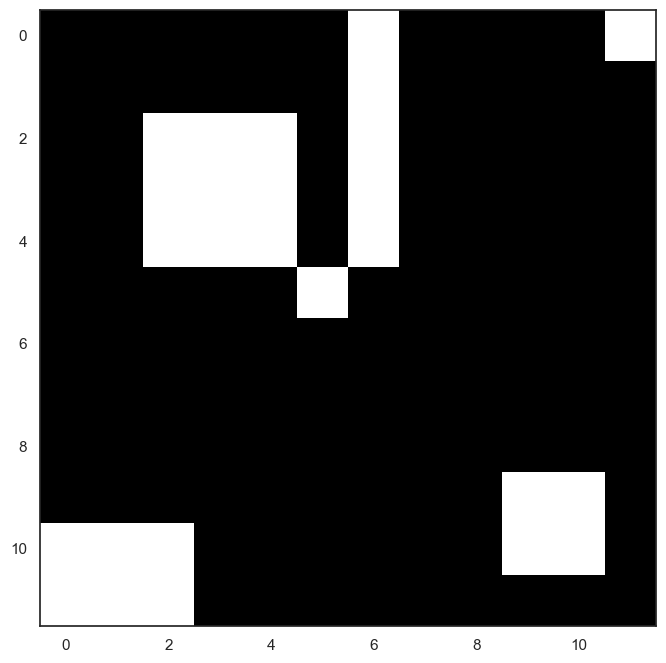

In [5]:
# A hacky way to create animated plot of DFS progress
fig = plt.figure()
plt.xticks([])
plt.yticks([])
for frame in range(len(grid_traversal)):
    plt.imshow(grid_traversal[frame], cmap='gray', interpolation=None)
    plt.show()
    sleep(0.1)
    clear_output(wait=True)

In [6]:
# A utility function to create and save animation of DFS progress
def make_animation(dfs_progress, interval_in_s=0.2):
    fig = plt.figure()
    raster = plt.imshow(dfs_progress[0], cmap='gray', interpolation=None);
    plt.xticks([])
    plt.yticks([])
    def update_plot(frame):
        raster.set_data(dfs_progress[frame])
        return raster
    anim = FuncAnimation(fig, update_plot, frames=len(dfs_progress), interval=1000*interval_in_s)
    anim.save('particle_detection.mp4', writer='ffmpeg', fps=len(dfs_progress)/(interval_in_s*len(dfs_progress)))

In [7]:
# A utility function to print key properties for an image
def print_img_info(image):
    print(f'Data type, geometry & pixel values of image: {image.dtype}, {image.shape}, {image.min()}-{image.max()}')

In [8]:
# A utility function to calculate size (row and column dimensions) of output image
def calc_output_img_size(image, max_dim_of_output=256):
    if np.argmax(image.shape) == 0:
        aspect_ratio = image.shape[1]/image.shape[0]
        ncols = int(np.around(max_dim_of_output*aspect_ratio))
        nrows = max_dim_of_output
    elif np.argmax(image.shape) == 1:
        aspect_ratio = image.shape[0]/image.shape[1]
        ncols = max_dim_of_output
        nrows = int(np.around(max_dim_of_output*aspect_ratio))
    return nrows, ncols

In [9]:
# Create image processing pipeline that processes raw images of marine snow
def process_image(image_fpath, max_dim_of_output=256, verbose=False):
    # Load image from file
    image = skimage.io.imread(image_fpath)
    
    # Convert color image to grayscale image
    image_gray = rgb2gray(image)
    
    # Sharpen image using unsharp masking technique
    # enhanced image = original + amount * (original - blurred)
    image_sharpened = unsharp_mask(image_gray, radius=2, amount=1) # radius -> sigma for Gaussian kernel/filter
    
    # Convert grayscale image to binary image
    # Binarize grayscale image using locally adaptive thresholding
    neighborhood_size = 2*np.floor(image_sharpened.size/16)+1
    local_thresh_value = threshold_local(image_sharpened, block_size=neighborhood_size, offset=0)
    image_binary = (image_sharpened > local_thresh_value)
    
    # Fill holes in binary objects
    image_filled = binary_fill_holes(image_binary)
    
    # If necessary, reduce size of image
    # Resize image using interpolation to match desired size
    if image.shape[0] > max_dim_of_output or image.shape[1] > max_dim_of_output:
        img_nrows, img_ncols = calc_output_img_size(image_filled, max_dim_of_output=max_dim_of_output)
        image_resized = resize(image_filled, output_shape=(img_nrows, img_ncols), anti_aliasing=False).astype(int)
        image_processed = image_resized
    else:
        image_resized = np.empty_like(image_filled)*np.nan
        image_processed = image_filled
    
    if verbose:
        print_img_info(image)
        print_img_info(image_gray)
        print_img_info(image_sharpened)
        print_img_info(image_binary)
        print_img_info(image_filled)
        print_img_info(image_resized)
        
        img_process_pipeline = dict(
            Original=image,
            Grayscale=image_gray,
            Sharpened=image_sharpened,
            Binary=image_binary,
            Filled=image_filled,
            Downsized=image_resized)
        
        return img_process_pipeline
    
    else:
        return image_processed

Data type, geometry & pixel values of image: uint8, (279, 450, 3), 0-255
Data type, geometry & pixel values of image: float64, (279, 450), 0.0-0.9986011764705882
Data type, geometry & pixel values of image: float64, (279, 450), 0.0-1.0
Data type, geometry & pixel values of image: bool, (279, 450), False-True
Data type, geometry & pixel values of image: bool, (279, 450), False-True
Data type, geometry & pixel values of image: int64, (159, 256), 0-1


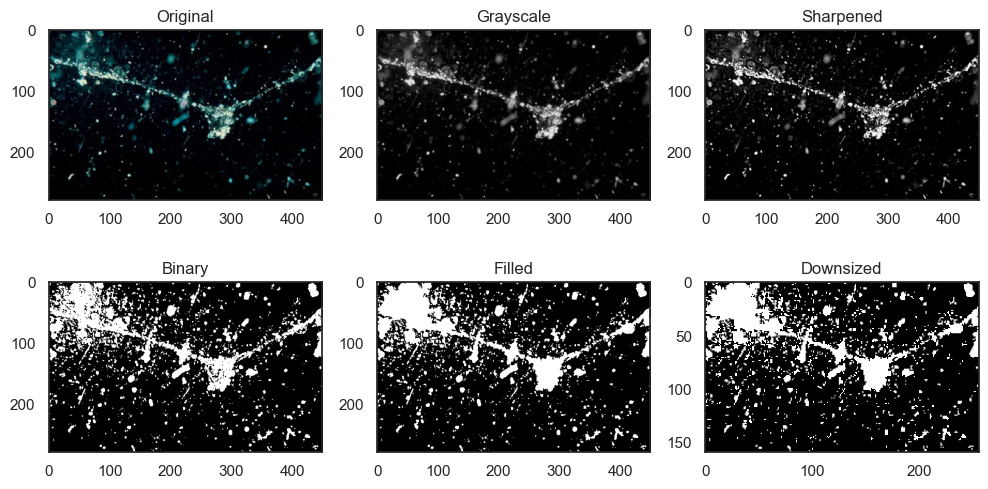

In [10]:
# Test image processing pipeline on a raw image of marine snow
img_process_pipeline = process_image('images/v40n2-honjo2en_4950.jpg', max_dim_of_output=256, verbose=True)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for ax, (img_title, image) in zip(axs.reshape(-1), img_process_pipeline.items()):
    if image.ndim == 2:
        ax.imshow(image, cmap='gray', interpolation=None);
    else:
        ax.imshow(image, interpolation=None);
    ax.set_title(img_title);

In [11]:
# Test "island" counting function on the processed image of marine snow
img_processed = process_image('images/v40n2-honjo2en_4950.jpg', max_dim_of_output=256, verbose=False)
%time num_particles, dfs_progress = count_islands(img_processed, return_frames=True)
print(f'Number of marine particles found is: {num_particles}')

CPU times: user 671 ms, sys: 620 ms, total: 1.29 s
Wall time: 1.31 s
Number of marine particles found is: 799


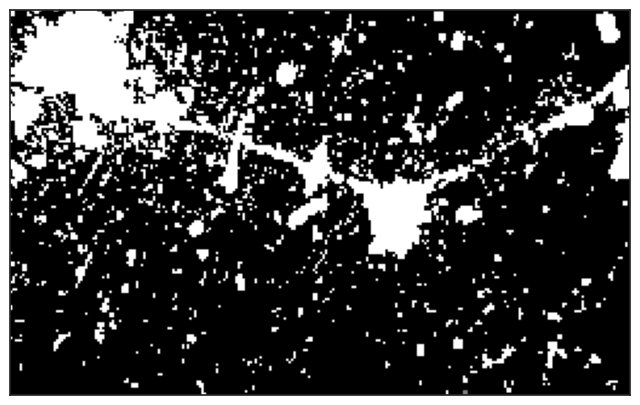

In [12]:
# Create and save animation of marine particle detection using DFS
make_animation(dfs_progress[::5], interval_in_s=0.01)

In [13]:
# A wrapper function to count number of marine particles in an image
def count_particles_in_image(image_fpath, max_dim_of_output=256):
    img_processed = process_image(image_fpath, max_dim_of_output=max_dim_of_output, verbose=False)
    num_particles = count_islands(img_processed, return_frames=False)
    return num_particles

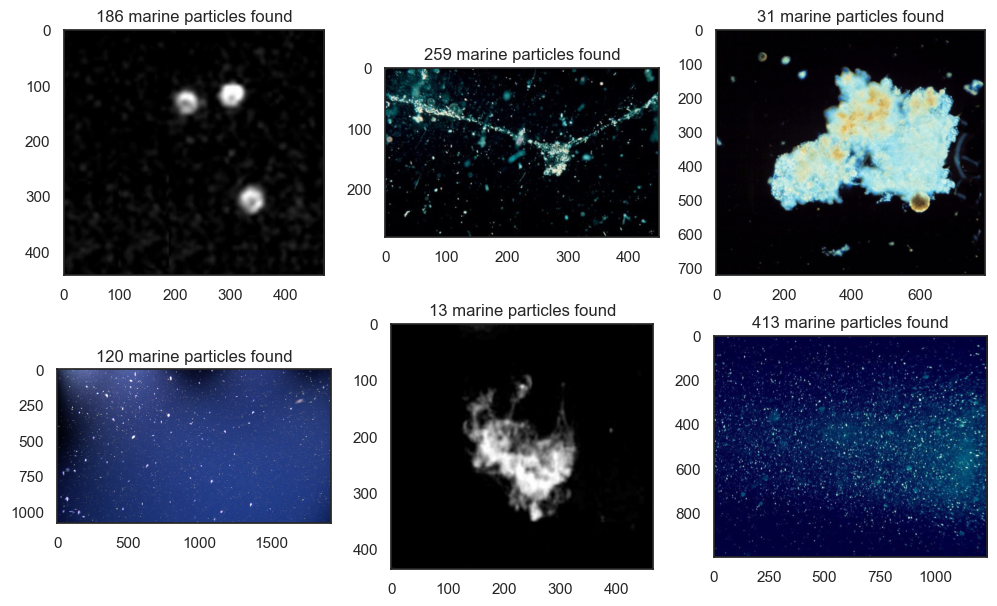

In [14]:
# Count number of particles in all (6) available images of marine snow
img_res = 96 # desired image resolution, e.g., 32x32, 64x64, 96x96, 128x128, 256x256, 512x512
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
for img_fpath, ax in zip(glob.glob('images/*.jpg'), axs.reshape(-1)):
    num_particles = count_particles_in_image(img_fpath, max_dim_of_output=img_res)
    ax.imshow(skimage.io.imread(img_fpath), interpolation=None);
    ax.set_title(f'{num_particles} marine particles found');